In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from typing import List, Tuple, Dict, Optional
import numpy as np
import seaborn as sns
from datetime import datetime
import requests
from dotenv import load_dotenv


In [6]:
load_dotenv()

BACKEND_USER = os.environ['BACKEND_USER']
BACKEND_PASSWORD = os.environ['BACKEND_PASSWORD']
BACKEND_URL = os.environ['BACKEND_URL']
BACKEND_URL = 'http://localhost:5050'
BACKEND_USER = 'admin'
BACKEND_PASSWORD = 'admin'

experiment_type = 'reward-network-iii-6A-v2'
experiment_type = 'reward-network-iii-6B-v1'
experiment_type = 'reward-network-iii-7B-v1'
experiment_type = 'reward-network-iii-8B-v1'
experiment_type = 'reward-network-iii-8A-v1'
experiment_type = 'test2'


finished = True


In [7]:
from common.utils.utils import estimate_solution_score, estimate_average_player_score
from common.models.network import Network


url = f'{BACKEND_URL}/results'
headers = {'Accept': 'application/json'}
auth = (BACKEND_USER, BACKEND_PASSWORD)
current_datatime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# #---subjects----
subjects = requests.get(f'{url}/subjects', headers=headers, auth=auth)
subjects_df = pd.DataFrame(subjects.json())
s_to_p = subjects_df.set_index('session_id')['prolific_id'].to_dict()

#---sessions----
sessions = requests.get(f'{url}/sessions?experiment_type={experiment_type}&finished={finished}', headers=headers, auth=auth)
sessions_json = sessions.json()



def eval_move(edge, all_edges):
    max_reward = max([e['reward'] for e in all_edges])
    min_reward = min([e['reward'] for e in all_edges])

    myopic = edge['reward'] == max_reward
    has_large_loss = min_reward == -50
    large_loss_taken = edge['reward'] == -50

    optimal = large_loss_taken if has_large_loss else myopic

    return {
        'myopic': myopic,
        'optimal': optimal,
        'large_loss_taken': large_loss_taken,
    }



def get_moves(network: dict, moves_nodes: List[int], correct_repeats: Optional[List[bool]] = None):
    edges_by_source = {}
    for edge in network['edges']:
        edges_by_source.setdefault(edge['source_num'], []).append(edge)

    edges_by_source_target = {
        source_num: {
            edge['target_num']: edge
            for edge in edges
        }
        for source_num, edges in edges_by_source.items()
    }


    nodes_by_num = {
        node['node_num']: node
        for node in network['nodes']
    }

    moves = []
    for i, (source_num, target_num) in enumerate(zip(moves_nodes[:-1], moves_nodes[1:])):
        print(i, source_num, target_num)
        edges = edges_by_source_target[source_num]
        edge = edges[target_num]
        moves.append({
            "move_idx": i,
            "source_num": source_num,
            "target_num": target_num,
            "reward": edge['reward'],
            "level": nodes_by_num[target_num]['level'],
            "correct_repeat": correct_repeats[i] if correct_repeats is not None else None,
            **eval_move(edge, edges.values())
        })
    return moves


written_strategies = []
p_moves = []
for session in sessions_json:
    for trial in session['trials']:
        if trial['solution'] is not None:
            pid = s_to_p[session['_id']]
            score = estimate_solution_score(Network(**trial['network']), trial['solution']['moves'], n_steps=10)
            assert score > 0, f"negative score {score} in session {session['_id']} for {trial['id']} of type {trial['trial_type']} pid {pid}"
            
            moves = get_moves(trial['network'], trial['solution']['moves'], trial['solution']['correctRepeats'])
            trials_info = {
                'session_id': session['_id'],
                'trial_id': trial['id'],
                'trial_type': trial['trial_type'],
                'score': trial['solution']['score'],
                'average_score': session['average_score'],
            }
            moves = [{**m, **trials_info} for m in moves]
            p_moves.extend(moves)
        if trial['written_strategy'] is not None and session['ai_player'] is False:
            written_strategies.append({
                'session_id': session['_id'],
                'trial_id': trial['id'],
                'text': trial['written_strategy']['strategy'],
            })


moves_df = pd.DataFrame(p_moves)
strategy_df = pd.DataFrame(written_strategies)

trials_df = pd.DataFrame([{**t, 'session_id': s['_id']} for s in sessions_json for t in s['trials']])
sessions_df = pd.DataFrame([{k: v for k, v in s.items() if k != 'trials'} for s in sessions_json])
session_idx = {s: i for i, s in enumerate(moves_df['session_id'].unique())}
trial_idx = {s: i for i, s in enumerate(moves_df['trial_id'].unique())}
wr_trial_idx = {s: i for i, s in enumerate(strategy_df['trial_id'].unique())}


moves_df['session_idx'] = moves_df['session_id'].apply(lambda x: session_idx[x])
moves_df['trial_idx'] = moves_df['trial_id'].apply(lambda x: trial_idx[x])

strategy_df['session_idx'] = strategy_df['session_id'].apply(lambda x: session_idx[x])
strategy_df['ws_idx'] = strategy_df['trial_id'].apply(lambda x: wr_trial_idx[x])

strategy_df = strategy_df.sort_values(by=['session_idx', 'ws_idx'])


# create folder
os.makedirs(os.path.join('./data/pilots/',experiment_type), exist_ok=True)

strategy_df.to_csv(os.path.join('./data/pilots/',experiment_type,'strategy.csv'), index=False)
moves_df.to_csv(os.path.join('./data/pilots/',experiment_type,'moves.csv'), index=False)
trials_df.to_csv(os.path.join('./data/pilots/',experiment_type,'trials.csv'), index=False)


KeyError: '65a9e1846467c239a14cc1e8'

In [ ]:
p_to_s

{'652d8f76c8e2808f2f7752b8': '63f5662c-a1d5-40ae-b4ab-b0cae4373923',
 '652d917bc8e2808f2f7752d9': 'd5e8317e-5769-4709-9bd5-fd779b4c0bd4',
 '652d93cffd3d6a70a168b46e': '06a16cf1-2bed-478b-a60b-a2d760856c21',
 '652e5969fd3d6a70a168b491': 'a69f6976-0b94-42a7-aff5-05e5ceea49df',
 None: '8178f0c3',
 '6541736d560ba8f34baee065': '05f11af1-2fd0-43ae-8015-365f26dab72c',
 '65417393560ba8f34baee06c': '04308e63-c88e-4f61-83ee-9d0a2cb7c78e',
 '65417393560ba8f34baee06d': 'f0f25e0c-91ab-4d39-8df1-25e11b40264d',
 '65417393560ba8f34baee06e': 'cc5efbbe-1b89-4fb0-bae7-bf76546a2c96',
 '65417393560ba8f34baee06f': '16c85bb4-e829-4727-a9ab-27f3d186bc6d',
 '6541779b560ba8f34baee082': '698d91fe-a838-4a4a-9a0f-60a7cc63086f',
 '65421e1a9b2b1e1b136058cd': 'a06ba60e-5715-483c-9caf-0e74d9fdce18',
 '65421e1a9b2b1e1b136058ce': '36d6787d-e400-4931-bbb0-d03821d98bd4',
 '654220a648b060e3ebfe68bf': 'f50baa39-f6fa-4600-b6b5-d051b3cc4b21',
 '65425cdc48b060e3ebfe68cf': '38beae9d-ae1e-4167-9d87-23474cff42cd',
 '65425cdc48b06

In [ ]:
trial['solution']

{'moves': [4, 7, 1, 8, 5, 1, 8, 5, 1, 8],
 'correctRepeats': None,
 'score': -100000,
 'trial_id': None,
 'finished_at': None,
 'solution_type': 'machine_0'}

In [ ]:
trial['network']

{'network_id': 'e1b54b78838f8f643e41b7cf74c1b3ce',
 'nodes': [{'node_num': 0,
   'display_name': 'A0',
   'node_size': 3,
   'starting_node': False,
   'level': 0,
   'x': 100.0,
   'y': -1.9702865314610764e-06},
  {'node_num': 1,
   'display_name': 'B3',
   'node_size': 3,
   'starting_node': False,
   'level': 3,
   'x': 86.60253909248031,
   'y': -50.00000096860836},
  {'node_num': 2,
   'display_name': 'C0',
   'node_size': 3,
   'starting_node': False,
   'level': 0,
   'x': 49.99999802144599,
   'y': -86.60254501987487},
  {'node_num': 3,
   'display_name': 'D1',
   'node_size': 3,
   'starting_node': False,
   'level': 1,
   'x': -2.3677824115544896e-06,
   'y': -99.9999999669302},
  {'node_num': 4,
   'display_name': 'E0',
   'node_size': 3,
   'starting_node': True,
   'level': 0,
   'x': -50.00000295542987,
   'y': -86.6025390594105},
  {'node_num': 5,
   'display_name': 'F3',
   'node_size': 3,
   'starting_node': False,
   'level': 3,
   'x': -86.60253508576766,
   'y': -50

In [ ]:
trial['network']['starting_node']

4

In [ ]:
for e in trial['network']['edges']:
    print(e['source_num'], e['target_num'], e['reward'])

0 9 200
0 4 100
0 3 -50
1 8 400
1 7 200
2 0 100
2 11 0
2 4 200
3 10 -50
3 6 100
3 9 200
4 6 -50
4 0 200
4 3 -50
5 1 400
5 10 200
6 11 200
6 7 -50
7 4 200
7 1 -50
8 7 200
8 5 400
9 3 -50
9 2 0
9 0 200
10 5 -50
10 11 200
11 2 0
11 9 100
11 6 -50


In [ ]:
subjects

<Response [401]>

In [ ]:
session['trials'][11]['solution']


{'moves': [8, 3, 11, 7, 3, 11, 7, 3, 11, 7, 3],
 'correctRepeats': None,
 'score': 2100,
 'trial_id': 11,
 'finished_at': '2023-11-30T22:37:54.807000',
 'solution_type': None}

In [ ]:
sessions_no_ai_player = sessions_df[sessions_df['ai_player'] == False]['_id'].unique()
moves_df = moves_df[moves_df['session_id'].isin(sessions_no_ai_player)]


In [ ]:
moves_df['trial_type'].unique()


array(['individual', 'demonstration'], dtype=object)

In [ ]:

# df = moves_df.copy()

# df = df.sort_values(by=['average_score'])

# df = df[df['trial_type'].isin(['repeat'])]

# moves_matrix = df.pivot_table(index=['average_score', 'session_idx', 'move_idx'], columns=['trial_idx'], values='correct_repeat')
# n_sessions = len(moves_matrix.index.levels[0])

# # Original nodes and colors
# nodes = np.array([-50, 0, 400])
# colors = ["red", "yellow", "green"]

# # Normalize nodes to be in the range [0, 1]
# norm_nodes = (nodes - nodes.min()) / (nodes.max() - nodes.min())
# cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(zip(norm_nodes, colors)))

# plt.figure(figsize=(8, n_sessions))

# sns.heatmap(moves_matrix, cmap=cmap, cbar=False)


In [ ]:
df


,move_idx,source_num,target_num,reward,level,correct_repeat,myopic,optimal,large_loss_taken,session_id,trial_id,trial_type,score,average_score,session_idx,trial_idx
1234,2,4,9,-50,3,None,False,True,True,6568f759464e933804a0fb4d,14,repeat,2750,1187,11,13
1233,1,8,4,-50,2,None,False,True,True,6568f759464e933804a0fb4d,14,repeat,2750,1187,11,13
1232,0,1,8,-50,1,None,False,True,True,6568f759464e933804a0fb4d,14,repeat,2750,1187,11,13
1235,3,9,2,400,3,None,True,True,False,6568f759464e933804a0fb4d,14,repeat,2750,1187,11,13
1236,4,2,9,400,3,None,True,True,False,6568f759464e933804a0fb4d,14,repeat,2750,1187,11,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2770,4,6,1,400,3,None,True,True,False,6568f75b464e933804a0fb5a,14,repeat,2750,2750,24,13
2769,3,1,6,400,3,None,True,True,False,6568f75b464e933804a0fb5a,14,repeat,2750,2750,24,13
2768,2,2,1,-50,3,None,False,True,True,6568f75b464e933804a0fb5a,14,repeat,2750,2750,24,13
2767,1,3,2,-50,2,None,False,True,True,6568f75b464e933804a0fb5a,14,repeat,2750,2750,24,13


<Axes: xlabel='trial_idx', ylabel='average_score-session_idx-move_idx'>

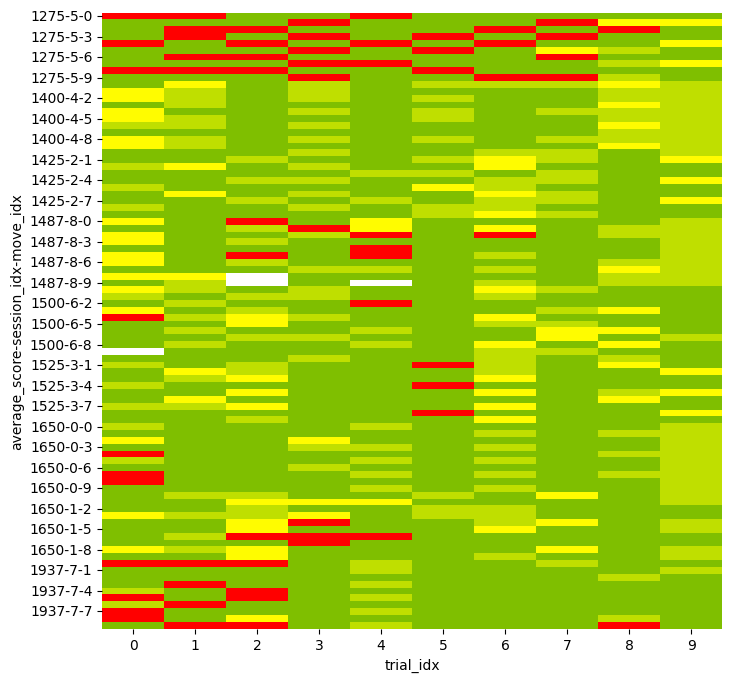

In [ ]:
moves_df = moves_df.sort_values(by=['average_score'])

moves_matrix = moves_df.pivot_table(index=['average_score', 'session_idx', 'move_idx'], columns=['trial_idx'], values='reward')
n_sessions = len(moves_matrix.index.levels[0])

# Original nodes and colors
nodes = np.array([-50, 0, 400])
colors = ["red", "yellow", "green"]

# Normalize nodes to be in the range [0, 1]
norm_nodes = (nodes - nodes.min()) / (nodes.max() - nodes.min())
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(zip(norm_nodes, colors)))

plt.figure(figsize=(8, n_sessions))

sns.heatmap(moves_matrix, cmap=cmap, cbar=False, vmin=-50, vmax=400)


In [ ]:
moves_matrix


trial_idx                               0      1      2      3      4      5  \
average_score session_idx move_idx                                             
1275          5           0         -50.0  -50.0  200.0  200.0  -50.0  200.0   
                          1         200.0  200.0  200.0  -50.0  200.0  200.0   
                          2         200.0  -50.0  -50.0  200.0  200.0  200.0   
                          3         200.0  -50.0  200.0  -50.0  200.0  -50.0   
                          4         -50.0  200.0  -50.0  200.0  -50.0  200.0   
...                                   ...    ...    ...    ...    ...    ...   
1937          7           5         -50.0  200.0  -50.0  200.0  100.0  200.0   
                          6         100.0  -50.0  200.0  200.0  200.0  200.0   
                          7         -50.0  200.0  200.0  200.0  100.0  200.0   
                          8         -50.0  200.0    0.0  200.0  200.0  200.0   
                          9         200.0  -50.0  -50.0  200.0  100.0  200.0   

trial_idx                               6      7      8      9  
average_score session_idx move_idx                              
1275          5           0         200.0  200.0  200.0  200.0  
                          1         200.0  -50.0    0.0    0.0  
                          2         -50.0  200.0  -50.0  200.0  
                          3         200.0  -50.0  200.0  200.0  
                          4         -50.0  200.0  200.0    0.0  
...                                   ...    ...    ...    ...  
1937          7           5         200.0  200.0  200.0  200.0  
                          6         200.0  200.0  200.0  200.0  
                          7         200.0  200.0  200.0  200.0  
                          8         200.0  200.0  100.0  200.0  
                          9         200.0  200.0  -50.0  200.0  

[90 rows x 10 columns]

<Axes: xlabel='trial_idx', ylabel='session_idx'>

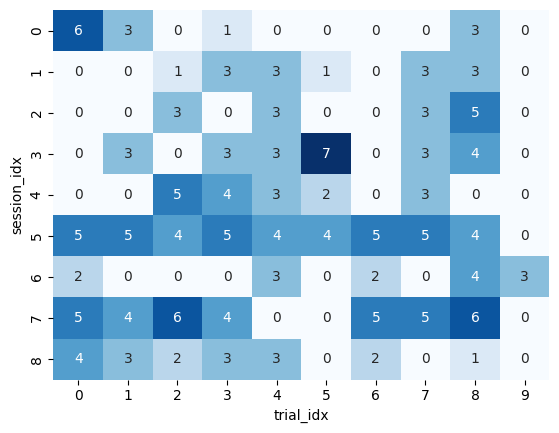

In [ ]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trial_idx'], values='optimal', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


<Axes: xlabel='trial_idx', ylabel='session_idx'>

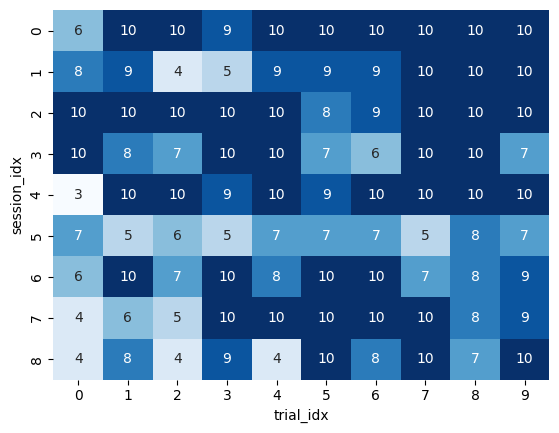

In [ ]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trial_idx'], values='myopic', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


<Axes: xlabel='trial_idx', ylabel='session_idx'>

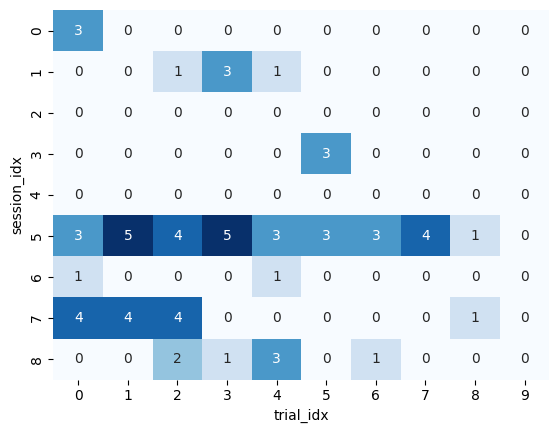

In [ ]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trial_idx'], values='large_loss_taken', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


In [ ]:
# large_loss_taken, myopic, optimal

moves_behavior = moves_df.melt(id_vars=['session_idx', 'trial_idx'], value_vars=['large_loss_taken', 'myopic', 'optimal'], var_name='behavior', value_name='count')


<Axes: xlabel='trial_idx', ylabel='count'>

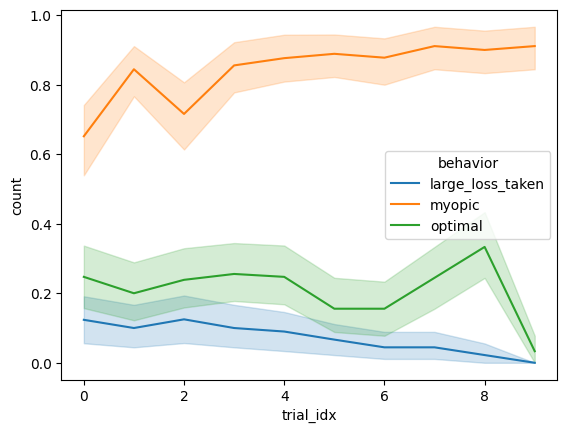

In [ ]:
sns.lineplot(data=moves_behavior, x='trial_idx', y='count', hue='behavior')


<Axes: xlabel='trial_idx', ylabel='reward'>

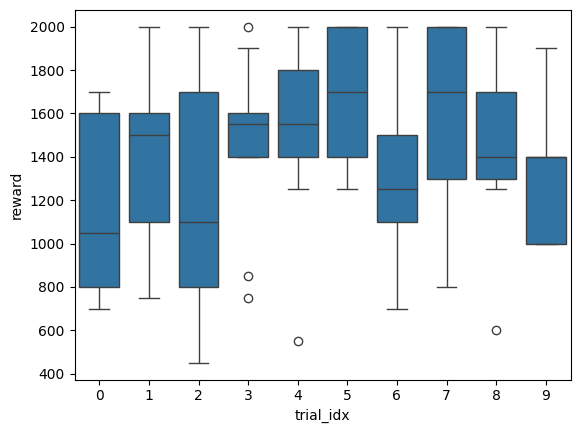

In [ ]:
df_group = moves_df.groupby(['session_idx', 'trial_idx'])['reward'].sum().reset_index()

sns.boxplot(data=df_group, x='trial_idx', y='reward')


In [ ]:
trials_df[trials_df['trial_type'] == 'written_strategy']['written_strategy'].iloc[0]


{'strategy': "pay attention to the options of the areas you'll be able to choose from before you choose which spot to go to",
 'trial_id': 6,
 'finished_at': '2023-11-30T22:11:47.891000'}